# This notebook explores why the trace is offset from the true $E_0$ and $J_0$ values.

In [134]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
import scipy.interpolate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

Create a true exponential spectra with E0t and J0t parameters. Then use that spectra and fold it through the MagEIS response functions to get the true counts.

In [135]:
# Spectra parameters
E0t = 100 # keV
J0t = 1E4 # 1/(cm^2 sr s keV)

# Initialize the response function
R = mageis_response.R_iso(101) # RBSP-A MagEIS LOW.
E = R.E*1000 # Energy array in keV.
FEDU_energy = [ 15.,  20.,  33.,  54.,  80., 108., 143., 184., 226.] # keV
n_ch = (1, 9) # Channels to use (1 through 9 are the main rate channels.)

# Interpolate the response functions so we can easily add uncertainty to them
# G is a function of energy that returns G(E) for all energy channels.
G = scipy.interpolate.interp1d(E, [R.response(i) for i in range(*n_ch)], axis=1)

# Define an exponential spectra.
def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(n_ch[1]-n_ch[0])
for i in range(*n_ch):
    true_lambda[i-n_ch[0]] = scipy.integrate.trapz(spectra(E, J0t, E0t)*R.response(i), x=E)

Since pymc3 does not natively do integrationm, now we code in a trapezium integrator (validated). Also define a pumc3 exponential spectra.

In [136]:
def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

def pymcExpSpectra(E, E0, J0):
    return J0*pm.math.exp(-E/E0)

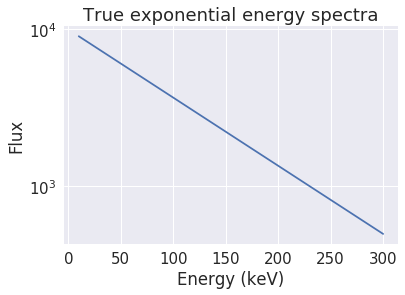

In [137]:
plt.plot(E, spectra(E, J0t, E0t)); plt.title('True exponential energy spectra')
plt.yscale('log'); plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

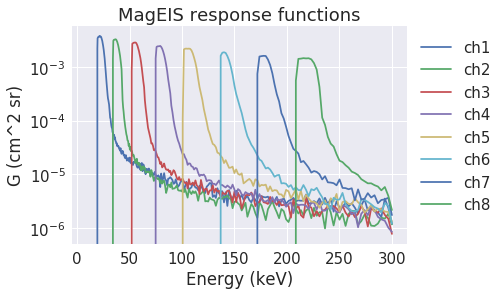

In [138]:
for i in range(*n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS response functions'); plt.yscale('log');
plt.legend(bbox_to_anchor=(1, 1)); #plt.savefig('response.png', dpi=300)

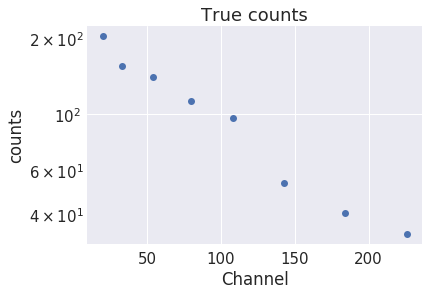

In [139]:
plt.semilogy(FEDU_energy[n_ch[0]:n_ch[1]], true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now add realism by drawing observed counts from true_lambda assuming a Poisson process

In [140]:
np.random.seed(123)
c_obs = np.random.poisson(true_lambda)

Visualize the counts derived from the spectra without uncertainty, and the counts that could have been observed if we assume a poisson process

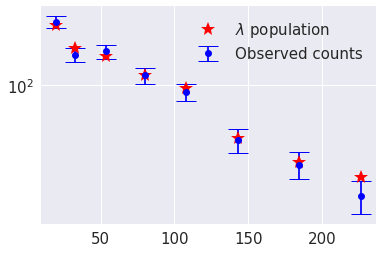

In [141]:
(_, caps, _) = plt.errorbar(FEDU_energy[n_ch[0]:n_ch[1]], c_obs, yerr=np.sqrt(c_obs), c='b', fmt='o', 
                            label='Observed counts', capsize=10)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(FEDU_energy[n_ch[0]:n_ch[1]], true_lambda, 'r*', ms=15, 
         label=r'$\lambda$ population')
plt.yscale('log'); plt.legend();

### Bayes model
Here we explore how to back out the exponential spectra from the observed counts. We work with informed and uninformed spectral parameter priors (switch below) and add uncertnaity to the response functions (scale up/down, move left/right).

In [142]:
informedPrior = True # use uniform or normal priors on J0 and E0.
# This sets the R(E) scale to unity or normally distributed.
# If False, will not modify the response functions.
Roffset = 0 # R(E) fwhm amplitude offset off if 0 (percent) 
Eoffset = 0 # R(E) fwhm energy offset off if 0 (percent)

def getPriors(informedSpecP, Roffset, Eoffset):
    """
    This function handles the exponential spectra priors, 
    and can add uncertnaity to the G(E) emplitude and
    energy offset.
    """
    if informedSpecP:
        BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
        J0 = BoundedNormal('J0', mu=1E4, sd=1E5)
        E0 = BoundedNormal('E0', mu=100, sd=10)
    else:
        J0 = pm.Uniform('J0', lower=0, upper=1E7)
        E0 = pm.Uniform('E0', lower=0, upper=500)
    
    # G(E) modifications
    if Roffset:
        Roff = pm.Normal('Roff', mu=1, 
                         sd=Roffset/(100*2*np.sqrt(2*np.log(2))), 
                         shape=len(c_obs))
    else:
        Roff = np.ones_like(c_obs)
    if Eoffset:
        Eoff = pm.Normal('Eoff', mu=1, 
                         sd=Eoffset/(100*2*np.sqrt(2*np.log(2))), 
                         shape=len(c_obs))
    else:
        Eoff = np.ones_like(c_obs)
    return E0, J0, Roff, Eoff

def lam(E0, J0, Roffset, Eoffset):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    My implementation of trapezium is not the fastest, but it will do.
    """
    lams = len(c_obs)*[None]
    
    for i in range(len(c_obs)):
        J = pymcExpSpectra(E*Eoffset[i], E0, J0)
        #f is chanel-dependent offset * flux arr * interpolated 
        # G(E * a random energy offset)
        f = Roffset[i]*J*G(E)[i]  #G(E*Eoffset[i])[i] 
        lams[i] = pm.Deterministic('lam{}'.format(i), pymcTrapz(f, E))
    return lams

m = pm.Model()
with m:
    # Prior stocastic variables
    prior = getPriors(informedPrior, Roffset, Eoffset)
    lams = lam(*prior) # Get prior determanistic variables
    
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs)) # Likelyhood
    trace = pm.sample(1E4, tuning=10, cores=3) # MCMC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [E0_lowerbound__, J0_lowerbound__]
100%|██████████| 10500/10500.0 [00:24<00:00, 432.55it/s]
The acceptance probability does not match the target. It is 0.8882068431909338, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9066180360408996, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


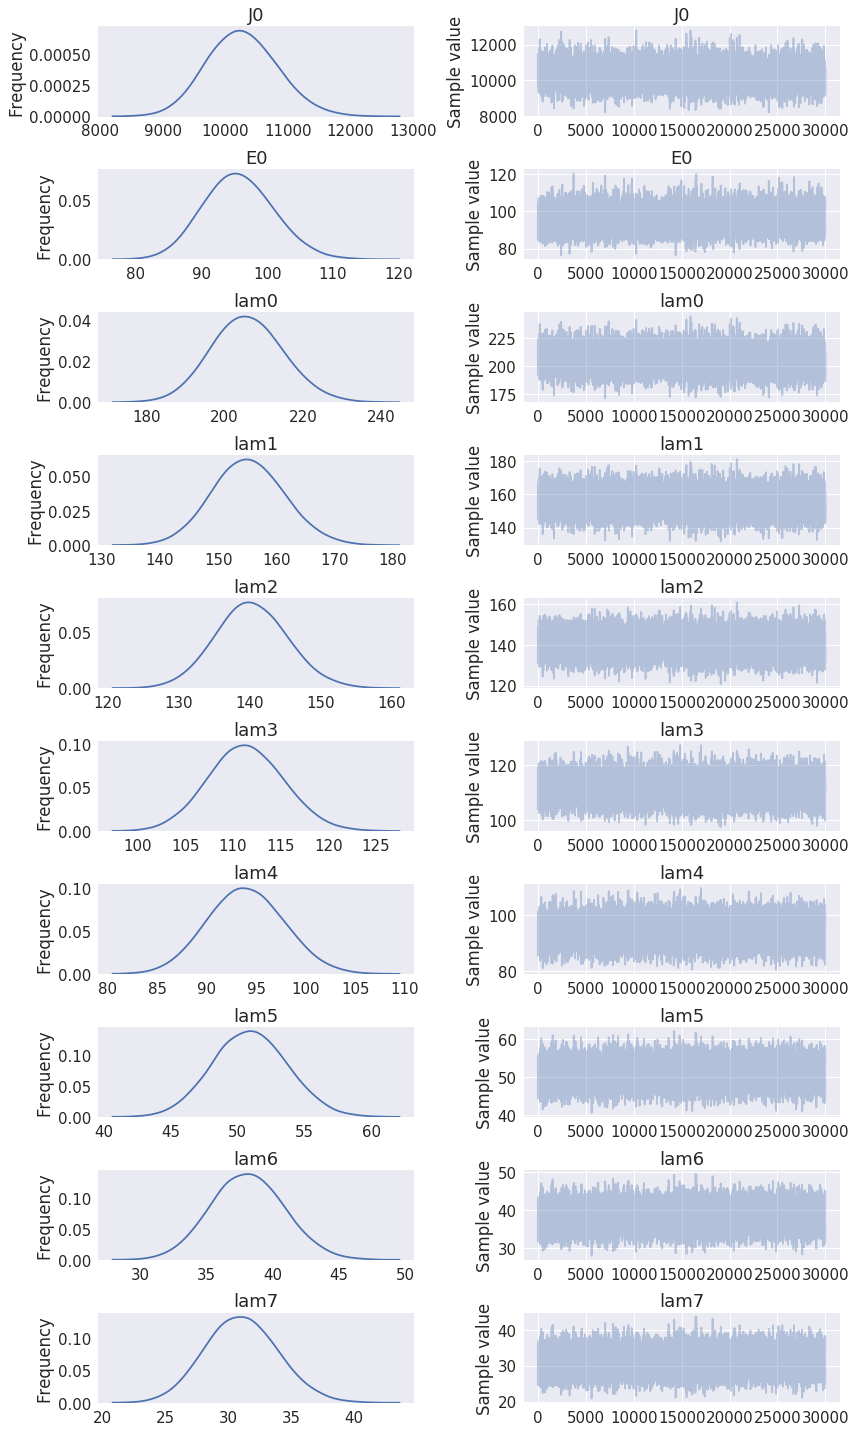

In [143]:
pm.traceplot(trace, combined=True);

In [144]:
pm.summary(trace)

mean          sd  mc_error      hpd_2.5      hpd_97.5  \
J0    10265.660634  565.764691  6.528587  9192.968193  11406.219405   
E0       95.590434    5.345540  0.060718    85.290427    106.112261   
lam0    205.712931    9.222984  0.099116   188.253831    224.280572   
lam1    155.123726    6.218041  0.061468   143.001874    167.336087   
lam2    140.218341    5.040300  0.041084   130.095868    149.957269   
lam3    111.322468    3.928895  0.022848   103.641683    118.981362   
lam4     93.907251    3.843183  0.021520    86.773373    101.745042   
lam5     50.897171    2.768949  0.020419    45.658282     56.430344   
lam6     38.057631    2.747921  0.023769    32.769128     43.471718   
lam7     31.033865    2.870286  0.026966    25.415908     36.647130   

             n_eff      Rhat  
J0     7559.165769  1.000413  
E0     7395.805118  1.000540  
lam0   8848.517933  1.000292  
lam1  10550.229847  1.000193  
lam2  15829.620713  1.000054  
lam3  28945.476785  0.999971  
lam4  28323.519465  1.000066  
lam5  16711.143899  1.000238  
lam6  12101.231831  1.000350  
lam7  10340.829244  1.000411

In [145]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_ci = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(len(c_obs))])

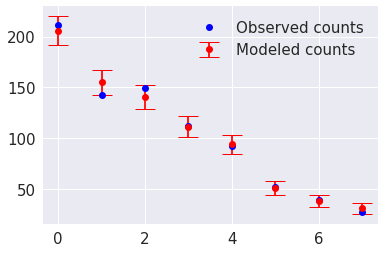

In [146]:
(_, caps, _) = plt.errorbar(range(len(c_obs)), c_mean, yerr=np.sqrt(c_mean), 
                            c='r', fmt='o', capsize=10, label='Modeled counts'); 
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(range(len(c_obs)), c_obs, 'bo', label='Observed counts'); 
plt.legend();

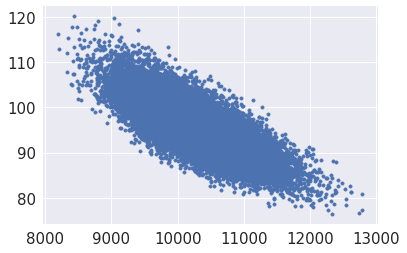

In [147]:
plt.scatter(trace['J0'], trace['E0'], marker='.');

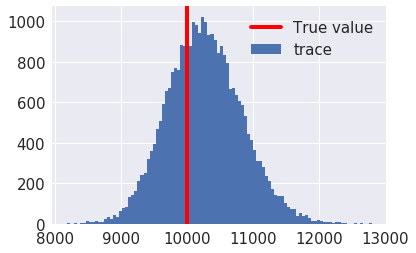

In [148]:
plt.hist(trace['J0'], bins=100, label='trace')
plt.axvline(J0t, c='r', lw=4, label='True value');
plt.legend();

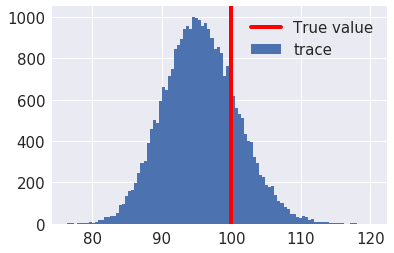

In [149]:
plt.hist(trace['E0'], bins=100, label='trace');
plt.axvline(E0t, c='r', lw=4, label='True value');
plt.legend();

## Posterior post predictive checks
Here we draw samples from the posterior distribution and check if the calculated counts from the picked E0 and J0 values are consistant with the data. Essentialy, we are looking to see if the observed counts are inside the drawn posterior distribution. 

In [150]:
ppc = pm.sample_ppc(trace, samples=2000, model=m)

100%|██████████| 2000/2000 [00:01<00:00, 1011.88it/s]


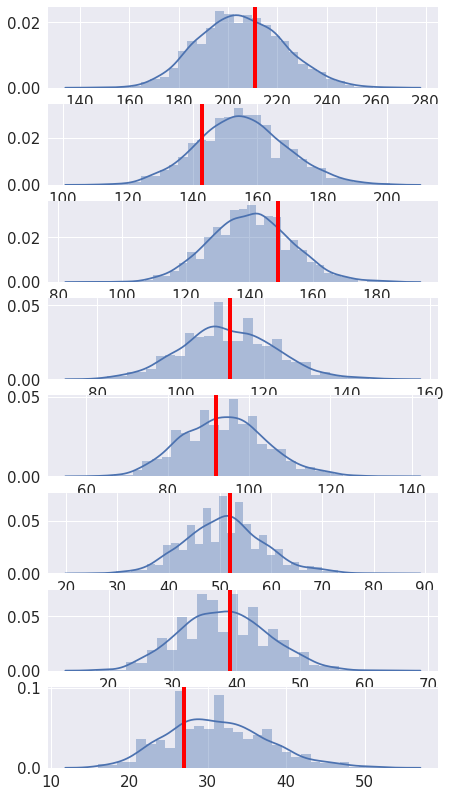

In [151]:
fig, ax = plt.subplots(len(c_obs),1, figsize=(7,14))
for i in range(len(c_obs)):
    sns.distplot(ppc['c_m'][:,i], ax=ax[i])
    ax[i].axvline(c_obs[i], c='r', lw=4)

## Statistics of the J0 and E0 distributions that are consistant with the observed counts 
Now we calculate the statistics of 100 spectra drawn from the trace (mean, median, 2.5%, and 95% credible interval) as a function of energy

Pick 100 random draws of E0 and J0 from the trace, and calculate the statistics on those draws as a function of energy.

In [152]:
nS = 100
random_samples = np.random.randint(0, len(trace), nS)
dist = np.zeros((len(E), nS), dtype=float)
for (i, s) in enumerate(random_samples):
    for e in range(len(E)):
        dist[e, i] = spectra(E, trace['J0'][s], trace['E0'][s])[e]

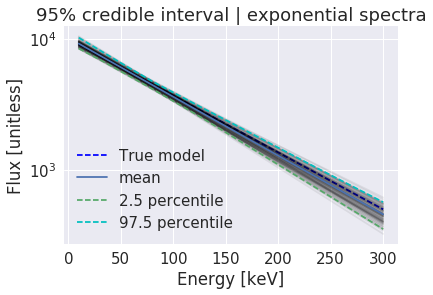

In [153]:
plt.plot(E, spectra(E, J0t, E0t), 'b--', label='True model')
for i in random_samples:
    plt.plot(E, spectra(E, trace['J0'][i], trace['E0'][i]), c='k', alpha=0.07)
plt.plot(E, np.mean(dist, axis=1), label='mean');
plt.plot(E, np.percentile(dist, 2.5, axis=1), '--', label='2.5 percentile')
plt.plot(E, np.percentile(dist, 97.5, axis=1), '--', label='97.5 percentile', c='c')
plt.legend(); plt.yscale('log'); plt.ylabel('Flux [unitless]');
plt.xlabel('Energy [keV]'); plt.title('95% credible interval | exponential spectra');

Calculate the credible intervals for E0 and J0

In [154]:
J0_ci = np.percentile(trace['J0'], (2.5, 97.5)); 
E0_ci = np.percentile(trace['E0'], (2.5, 97.5));

print('J0_ci = {}, E0_ci = {}'.format(J0_ci, E0_ci))

J0_ci = [ 9212.33300733 11428.46829482], E0_ci = [ 85.59129096 106.49453574]


### Investigate why there is a systematic discrepency in the trace vs the true spectra patrameter

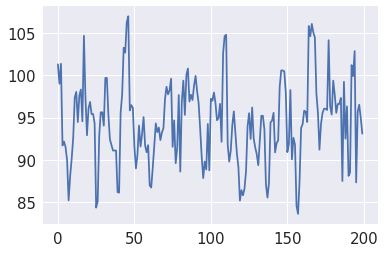

In [155]:
plt.plot(trace['E0'][0:200])